In [9]:
!pip install Prophet

     |████████████████████████████████| 8.9 MB 2.0 MB/s            
     |████████████████████████████████| 78 kB 2.1 MB/s            
     |████████████████████████████████| 83 kB 1.9 MB/s            
     |████████████████████████████████| 47 kB 2.8 MB/s            
     |████████████████████████████████| 208 kB 3.1 MB/s            
     |████████████████████████████████| 5.8 MB 1.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.8 MB 3.0 MB/s            
Using legacy 'setup.py install' for pymeeus, since package 'wheel' is not installed.
    Running setup.py install for pymeeus ... done


In [10]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import sklearn
import sklearn.pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble
from sklearn.utils import parallel_backend
from joblibspark import register_spark
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

/opt/bitnami/python/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
spark = SparkSession.builder.appName("Vu dep trai").config("spark.executor.memory","9g").getOrCreate()
# conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
#         .setAppName("Vu dep trai")\
#         .set("spark.executor.memory","15g")
# # sc = SparkContext.getOrCreate(conf=conf)
# # spark.stop()
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/05 17:05:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/05 17:05:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/02/05 17:05:13 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [12]:
df_train_raw = spark.read.csv("data/ba-walmart/train.csv", header=True, inferSchema=True)
df_train_raw = df_train_raw.drop("IsHoliday")
df_train_raw.show(5)

+-----+----+-------------------+------------+
|Store|Dept|               Date|Weekly_Sales|
+-----+----+-------------------+------------+
|    1|   1|2010-02-05 00:00:00|     24924.5|
|    1|   1|2010-02-12 00:00:00|    46039.49|
|    1|   1|2010-02-19 00:00:00|    41595.55|
|    1|   1|2010-02-26 00:00:00|    19403.54|
|    1|   1|2010-03-05 00:00:00|     21827.9|
+-----+----+-------------------+------------+
only showing top 5 rows



In [26]:
df = df_train_raw.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))
df_train = df_train_raw.withColumn("Store_Department", concat(col("Store"), lit("_"), col("Dept")))
df_train.show(5)


+-----+----+-------------------+------------+----------------+
|Store|Dept|               Date|Weekly_Sales|Store_Department|
+-----+----+-------------------+------------+----------------+
|    1|   1|2010-02-05 00:00:00|     24924.5|             1_1|
|    1|   1|2010-02-12 00:00:00|    46039.49|             1_1|
|    1|   1|2010-02-19 00:00:00|    41595.55|             1_1|
|    1|   1|2010-02-26 00:00:00|    19403.54|             1_1|
|    1|   1|2010-03-05 00:00:00|     21827.9|             1_1|
+-----+----+-------------------+------------+----------------+
only showing top 5 rows



In [27]:
df_pd = df.toPandas()

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


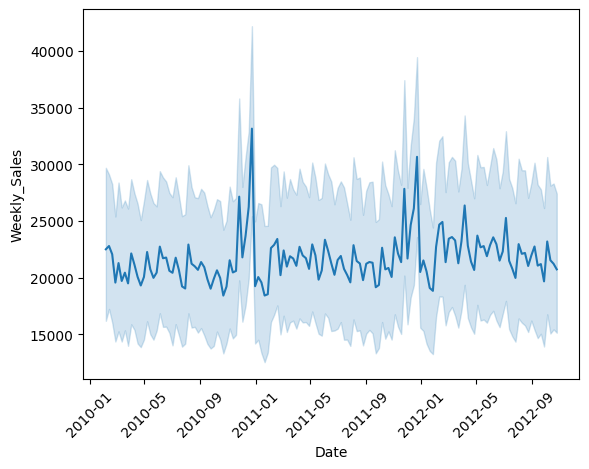

In [28]:
df_pd_1 = df_pd[(df_pd["Store"] == 1)]
sns.lineplot(x="Date", y="Weekly_Sales", data=df_pd_1)
_ = plt.xticks(rotation=45)

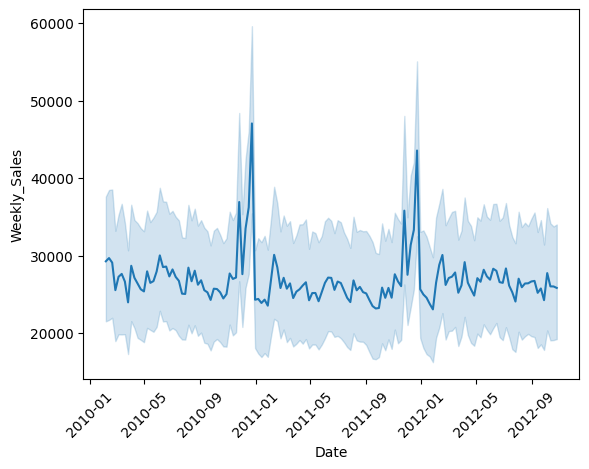

In [29]:
df_pd_1 = df_pd[(df_pd["Store"] == 2)]
sns.lineplot(x="Date", y="Weekly_Sales", data=df_pd_1)
_ = plt.xticks(rotation=45)

In [30]:
df_train, df_valid = df.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def apply_model(train_df, valid_df):
    model = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=True,
        )

        # fit the model
    model.fit(train_df)
    forecast = model.make_future_dataframe()

